# 1. Understand the SKA model architecture and training methodology

In [1]:
import torch
import torch.nn as nn
import numpy as np

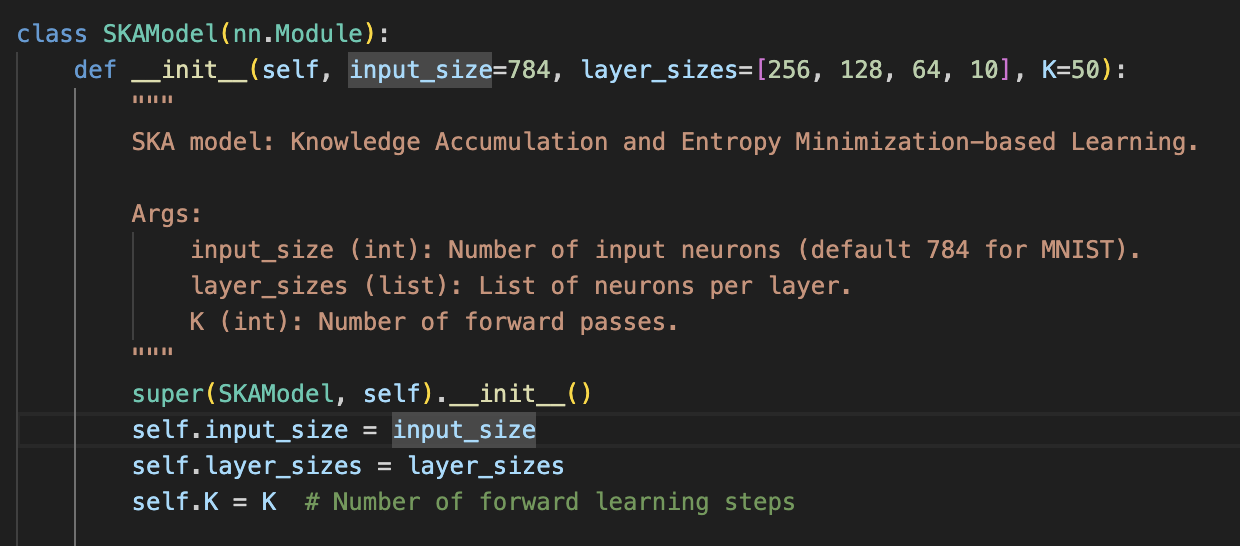

In [13]:
input_size = 10
layer_size = [10, 5, 3]
k = 5

### we define the input_size of the features and the layer_size defines the number of neurons in each layer

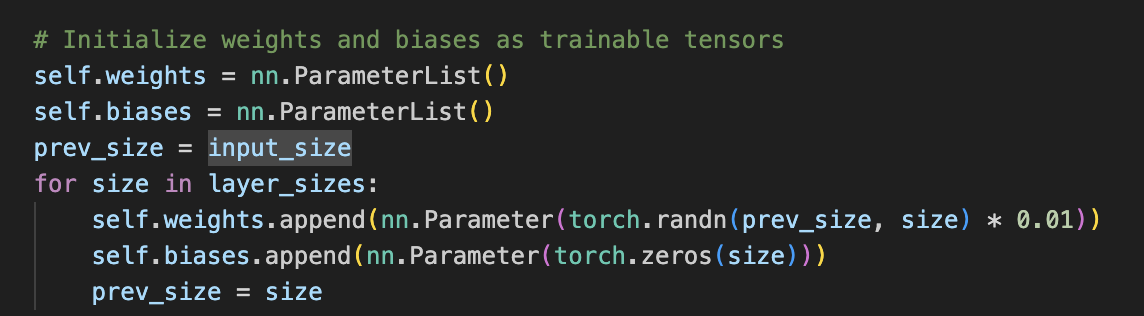

### we initilize the weights and bias for each of the layers

### algorithm understaing

### 1)assing self.weights and self.bias as the empty tourch list to store the weights and bias
### 2)traverse the layers list and generate the random values for the laywer 


In [15]:
# testing and understanding
print(nn.ParameterList()) # -> act as a list to store the weights and other data

torch.randn(2, 3) * 0.01

ParameterList()


tensor([[ 0.0145, -0.0072,  0.0130],
        [ 0.0006, -0.0017, -0.0085]])

In [19]:
#initlise the list to store the weights and the bias
weight = nn.ParameterList()
bias = nn.ParameterList()

#traverse the list of no of layer in each compartnemnt
prev_size = input_size
for size in layer_size:
    #generate the random list of shape prev_size * size
    weight.append(nn.Parameter(torch.randn(prev_size, size)*0.01))
    bias.append(nn.Parameter(torch.zeros(size)))
    

In [23]:
weight

ParameterList(
    (0): Parameter containing: [torch.float32 of size 10x10]
    (1): Parameter containing: [torch.float32 of size 10x5]
    (2): Parameter containing: [torch.float32 of size 10x3]
)

In [29]:
print(f"the weigth size in first layers is : {weight[0].size()}")
print(f"the weigth size in scond layers is : {weight[1].size()}")
print(f"the weigth size in third layers is : {weight[2].size()}")

the weigth size in first layers is : torch.Size([10, 10])
the weigth size in scond layers is : torch.Size([10, 5])
the weigth size in third layers is : torch.Size([10, 3])


In [30]:
weight[1]

Parameter containing:
tensor([[-0.0156, -0.0160,  0.0021, -0.0193, -0.0023],
        [ 0.0039, -0.0072,  0.0032, -0.0136, -0.0076],
        [-0.0046,  0.0173, -0.0064, -0.0021,  0.0072],
        [ 0.0214,  0.0057,  0.0073,  0.0051, -0.0202],
        [-0.0040,  0.0040,  0.0010,  0.0091, -0.0067],
        [ 0.0057, -0.0197,  0.0057,  0.0009,  0.0011],
        [ 0.0055, -0.0117, -0.0158,  0.0026,  0.0164],
        [ 0.0321,  0.0081,  0.0103,  0.0047,  0.0042],
        [ 0.0056,  0.0147,  0.0050,  0.0094, -0.0095],
        [-0.0110, -0.0093,  0.0153, -0.0005,  0.0008]], requires_grad=True)

In [21]:
bias

ParameterList(
    (0): Parameter containing: [torch.float32 of size 10]
    (1): Parameter containing: [torch.float32 of size 5]
    (2): Parameter containing: [torch.float32 of size 3]
)

In [26]:
bias[0]

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### we have declarad some empty dictionary to store teh data

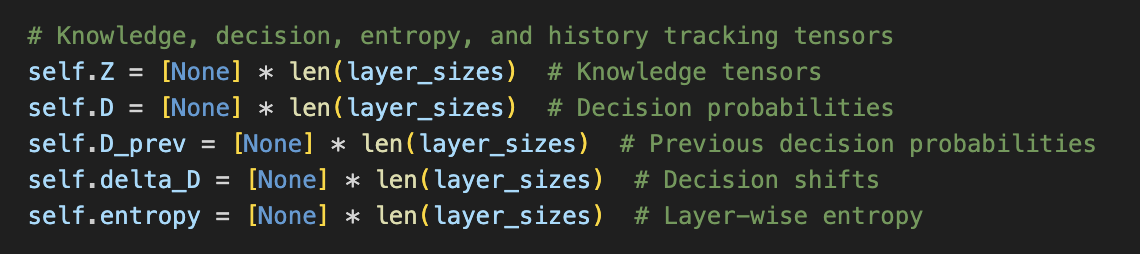

In [31]:
Z = [None]*len(layer_size)
D = [None]*len(layer_size)
D_prev = [None]*len(layer_size)
delta_d = [None]*len(layer_size)
entropy = [None]*len(layer_size)

In [33]:
print(f"the shape of Z is {len(Z)}")
print(f"the shape of D is {len(D)}")
print(f"the shape of D_prev is {len(D_prev)}")
print(f"the shape of delta_d is {len(delta_d)}")
print(f"the shape of entropy is {len(entropy)}")

the shape of Z is 3
the shape of D is 3
the shape of D_prev is 3
the shape of delta_d is 3
the shape of entropy is 3


### declared empty holders fo tore teh history of computation

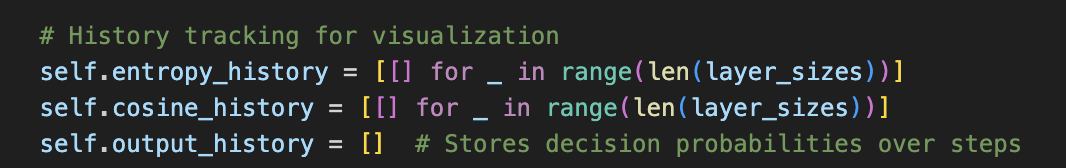

In [34]:
entropy_history = [[] for _ in range(len(layer_size))]
cosine_history = [[] for _ in range(len(layer_size))]
output_history = []

In [37]:
print(f"the len of entropy_history is {len(entropy_history)} * {len(entropy_history[0])}")
print(f"the len of cosine_history is {len(cosine_history)} * {len(cosine_history[0])}")
print(f"the size of the output history is : {len(output_history)}")


the len of entropy_history is 3 * 0
the len of cosine_history is 3 * 0
the size of the output history is : 0


### function to compute the forward pass

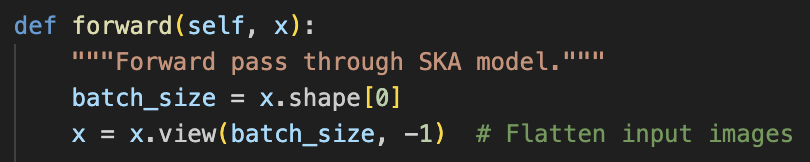

In [89]:
x = torch.full((10, 15), 10) 


In [90]:
x.shape

torch.Size([10, 15])

In [91]:
x

tensor([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]])

In [92]:
x.shape[0] # this line gets the number of batch in the dataset

10

In [93]:
batch_size = x.shape[0]

In [98]:
x.view(batch_size, -1)

tensor([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]])

In [95]:
x = x.view(batch_size, -1)

In [96]:
x.shape

torch.Size([10, 15])

### computing the Z vector and pass it to the next layers

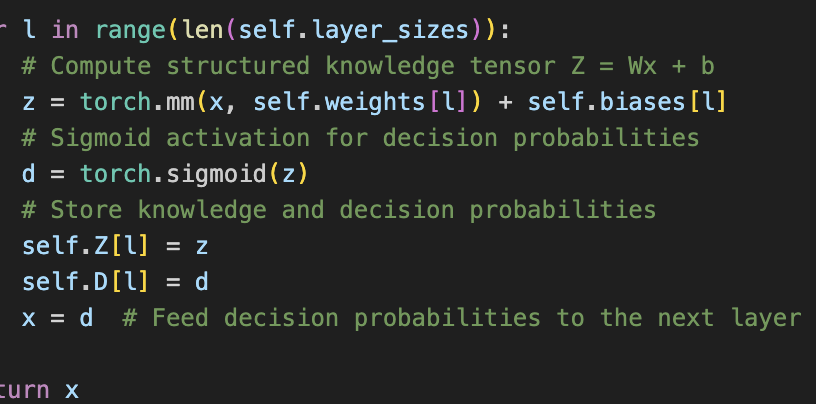

In [100]:
# traverse all the layers
# perform Z = wx + b
# pass to sigmoid
# pass to next layer of the neural network

### initilising the initial entropy

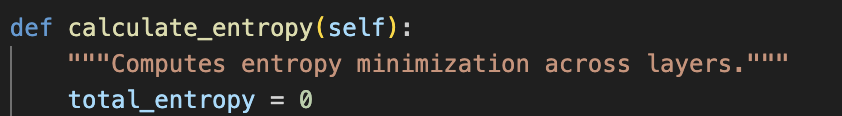

### iterating through all the layers

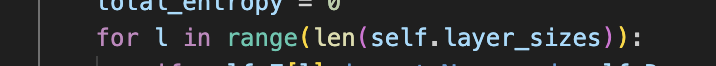

### checking if all the required values exist

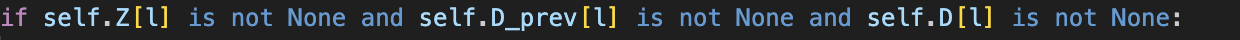

### computing the descion shift for each layers

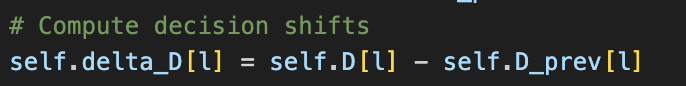

### Entropy calculation based on Structured Knowledge Acquisition (SKA):
### Computes the dot product between activations (Z[l]) i.e output of a layer  and decision shift (ΔD[l]).
### Multiplies by -1 / log(2) to normalize entropy.

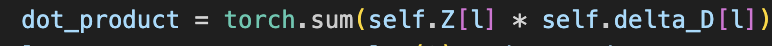